In [1]:
# sys, file and nav packages:
# import os
import datetime as dt
# import csv
# import json

# math packages:
import pandas as pd
import numpy as np
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac
import utilities.chart_kwargs as ck


# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-04-01'
end_date ='2021-04-01'

# the city, lake and river bassin we are aggregating to
# the keys are column names in the survey data
levels = {"city":"Biel/Bienne","water_name_slug":'bielersee', "river_bassin":'aare'}

# variables for the directory tree
most_recent, survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# name of the output folder:
name_of_project = 'keyindicatorsexample'

# add the folder to the directory tree:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

## <span style="color:#008891">Key statistical indicators of beach litter survey results</span>

#### <span style="color:#008891">Identification, quantification and analysis of observable anthropogenic debris along swiss river and lakes</span>

The key indicators are common relationships used to provide insight to the most frequent questions using parameters that are taken directly from the survey data. The key indicators are relatively easy to calculate and interpret. In this section we explain the key indicators and use examples from the current data. 

### <span style="color:#008891">Indicators for the most frequent questions</span>

1. What do you find?
2. How often do you find it?
3. How much do you find?
4. What else do you find?
5. Where do you find the most?

These are important questions to answer. The survey results are a census of objects that were primarily washed up on the beach. This helps answer the question:

> **What are we likely to find at the beach?**


> **What are we likely to find in the water?**

The key indicators differ between regions and locations.  Which may mean that the extent and/or nature of the problem is different from one region to another.

The reliability of these indicators is based on the following assumptions:

1. The more trash there is on the ground the more a person is likely to find
2. The survey results represent the minimum amount of trash at that site²
3. For each survey: finding one item does not effect the chance of finding another³


#### <span style="color:#008891">More information </span>

For information on a specific catchment area or a water feature see the notebook for that catchment area (or make one and send a pull request). For more information on the project visit https://www.plagespropres.ch/ .


¹ The EU guide on monitoring marine litter https://mcc.jrc.ec.europa.eu/documents/201702074014.pdfhttps://mcc.jrc.ec.europa.eu/documents/201702074014.pdf<br> ² There is most likely more trash at the survey site, but certainly not less than what was recorded.<br>³ Independent observations : https://stats.stackexchange.com/questions/116355/what-does-independent-observations-meanhttps://stats.stackexchange.com/questions/116355/what-does-independent-observations-mean


#### <span style="color:#008891">A brief reminder of the survey method</span>

A survey is a collection of observations. The observations correspond to the objects that were removed and counted during the survey. Each object is placed into one of 260 categories¹. The location, date, survey dimensions and the total number of objects in each category is noted.

Some locations are sampled monthly, other were only sampled once. 

#### <span style="color:#008891">The scope and size of the data for this example:</span>


In [2]:
# name the data sources and where to find them
# the easiest is to put them in the resources/most_recent directory
# the extension default is resources/most_recent/
data_sources = {    
    "survey_data":"results_with_zeroes.csv",
    "river_bassins":"river_basins.json",
    "beaches":"beaches_with_ranks.csv",
    "codes":"mlw_codes.csv",
    "code_groups":"code_group2.json",    
}

# define the methods to use for the .JSON and .csv files:
my_data_methods = {'json':ut.json_file_get, 'csv':pd.read_csv}

# get your data:
survey_data, river_bassins, dfBeaches, dfCodes, code_groups = ac.get_data_from_most_recent(data_sources, data_methods=my_data_methods)

# format the date to timestamp and slice the data by start/end date
dfSurveys = ac.fo_rmat_and_slice_date(survey_data.copy(), a_format="%Y-%m-%d", start_date=start_date, end_date=end_date)

# add the grouping column defined by river_bassins
data = ac.add_a_grouping_column(dfSurveys, river_bassins, column_to_match="water_name_slug")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# set the index of dfCodes to code:
dfCodes.set_index('code', inplace=True)

# make a map to the code descriptions
code_description_map = dfCodes.description

# put the data into a class
# kwargs for the abundance class
a_class_kwargs = dict(
    code_group_data=code_groups,
    levels=['river_bassin', 'water_name_slug', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects', 'pop_group_proj', 'pop_group_rip', 'streets_rank', 'buildings_rank'],       
    code_group_loc=output,    
)

# the data labled by river bassin, water feature, city and beach name with independent variables attached
a = ac.PreprocessData(data,  dfBeaches, these_cols=['loc_date', 'location', 'water_name_slug','date'], **a_class_kwargs)

# define the final data set here:
a_data = a.survey_data.copy()

# identify all records with a quantity > 0
a_data['fail'] = a_data.quantity > 0

# thats it! all the survey records with the independent variables attached and columns to group by
# date, location, (location, date), river bassin, water body, city, material, usage group, or object

# define the data set for this example:
trb = a_data.loc[a_data.river_bassin == levels['river_bassin']].copy()

# convenience method
def m_ap_code_to_description(data, key, func):
    new_data = data.copy()
    new_data['item'] = new_data.index.map(lambda x: func(x,key ))
    new_data.set_index('item', inplace=True)
    return new_data

# describe the data set:
num_obs = len(trb)
num_samps = len(trb.loc_date.unique())
num_obj = trb.quantity.sum()
num_locs = len(trb.location.unique())

# the city that we are looking at:
biel = trb[trb.city == levels['city']]

# samples at biel
biel_locd = biel.loc_date.unique()

# locations at biel
biel_loc = biel.location.unique()

# example data summary and keys
biel_t = biel.quantity.sum()
biel_fail = biel.loc[biel.quantity > 0]
biel_nfail = len(biel_fail.code.unique())

print(F"\n Results for all surveys between {start_date} and {end_date} from the following catchment areas:\n\n  {trb.river_bassin.unique()}")
print(F"\nThere are {'{:,}'.format(num_obs)} observations from {num_samps} surveys.\n\nThere were {'{:,}'.format(num_obj)} objects collected.")


 Results for all surveys between 2020-04-01 and 2021-04-01 from the following catchment areas:

  ['aare']

There are 28,288 observations from 128 surveys.

There were 12,875 objects collected.


### <span style="color:#008891">Fail rate: likelihood of finding an object</span>

#### The fail rate is the number of times that an object was found divided by the number of surveys.

**What does it mean?** The fail rate describes the percent of times that a category **was** identified in relation to the amount of surveys conducted

> Use the fail rate to determine how frequently an object is found within a geographic range

> Use the fail rate to indentify objects that are found frequently but in low numbers

In [3]:
print("\nConsider the summary of the surveys conducted in Biel/Bienne:")
print(F"\nThere were { '{:,}'.format( biel_t)} objects removed and identified in the course of { len(biel_locd) } surveys from {len(biel_loc)} locations.")
print(F"\nThe objects were placed in to the following {biel_nfail} of the {len(dfCodes)} possible categories:\n\n{biel_fail.code.unique()}\n")


Consider the summary of the surveys conducted in Biel/Bienne:

There were 3,067 objects removed and identified in the course of 16 surveys from 3 locations.

The objects were placed in to the following 118 of the 260 possible categories:

['G117' 'G213' 'G73' 'G152' 'G24' 'G87' 'G159' 'G3' 'G905' 'G170' 'G33'
 'G101' 'G178' 'G38' 'G939' 'G115' 'G211' 'G67' 'G95' 'G148' 'G23' 'G79'
 'G156' 'G27' 'G901' 'G167' 'G31' 'G100' 'G177' 'G35' 'G922' 'G112' 'G200'
 'G50' 'G941' 'G143' 'G22' 'G78' 'G153' 'G25' 'G89' 'G165' 'G30' 'G175'
 'G34' 'G917' 'G106' 'G186' 'G48' 'G940' 'G908' 'G41' 'G923' 'G21' 'G70'
 'G942' 'G4' 'G28' 'G904' 'G37' 'G191' 'G928' 'G10' 'G135' 'G68' 'G98'
 'G32' 'G936' 'G133' 'G66' 'G125' 'G8' 'G103' 'G93' 'G91' 'G916' 'G155'
 'G142' 'G7' 'G208' 'G26' 'G198' 'G921' 'G76' 'G927' 'G12' 'G150' 'G59'
 'G914' 'G197' 'G930' 'G171' 'G53' 'G913' 'G118' 'G137' 'G161' 'G104'
 'G188' 'G75' 'G43' 'G71' 'G20' 'G49' 'G918' 'G210' 'G2' 'G203' 'G919'
 'G195' 'G158' 'G929' 'G64' 'G96' 'G204

#### <span style="color:#008891">Calculate the fail rate per object category, for one city, lake and river basin</span>

The fail rate can be calculated for any lake, municipality or river bassin __provided you have a sufficient quantity of reliable data__. Biel/Bienne is a city on Bielersee in the Aare river bassin. There were multiple surveys from multiple locations within the river bassin.

**How much data is sufficient?** The data should cover the land use characteristics for the geographic and temporal scale appropriate to the area of study. Local authorities will have insight to land use characteristics that can greatly increase monitoring effiency. **How confident we are in the findings is directly related to the quality and the amount of data available**.

To calculate the fail rates for Biel, Bielersee and the Aare river basin we just add up the number of times a code was used and divide it by the number of surveys for the city, lake or river basin.

#### <span style="color:#008891">The 10 items identified the most often in Biel/Bienne</span>

Compare the fail-rates of the ten most common items from the 16 surveys in Biel to the fail-rates of those same items for Bielersee the Aare and all other river bassins

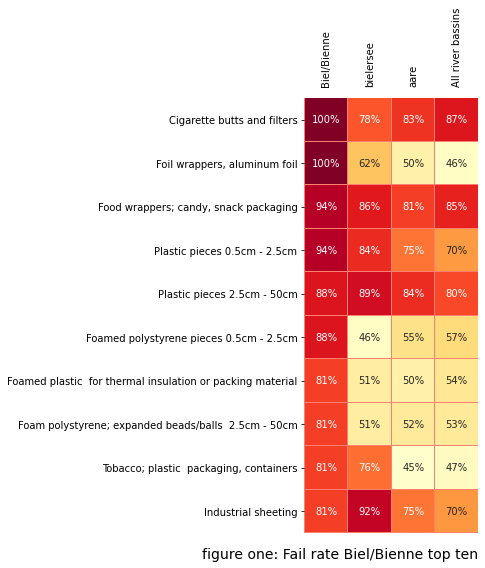

In [4]:
# this is a convenience function for the abundance class
# the fail rate needs to be recalculated at each aggregation level
fail_rates_df = ac.agg_fail_rate_by_city_feature_basin_all(a_data, levels, group='code')

# keep the list of top ten:
the_top_ten = fail_rates_df.sort_values(by='Biel/Bienne',ascending=False)[:10].index

# replace the GCODE with the description
fail_rates = m_ap_code_to_description(fail_rates_df, code_description_map, ut.use_this_key)

# plot that
fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(fail_rates.sort_values(by="Biel/Bienne", ascending=False)[:10], cmap='YlOrRd', annot=True, fmt='.0%', ax=ax, square=True, cbar=False, linewidth=.05, linecolor='salmon')
ax.tick_params(**ck.xlabels_top, **ck.no_xticks)
ax.set_ylabel("")
ax.set_xlabel("figure one: Fail rate Biel/Bienne top ten", **ck.label_r14)
plt.setp(ax.get_xticklabels(), rotation=90)
        
plt.tight_layout()
plt.show()

With the exception of fragmented plastics and plastic sheeting the fail rate for the top ten items in Biel/Bienne was greater than the rest of the lake, the river bassin and nationally. This means that, in general, there was a greater chance of finding those objects at Biel/Bienne than most other places. 

**The fail rate is not the probability of finding one object**, it is the most likely estimate (MLE) of the probability of finding one object. The MLE is the best estimate for the probability of a binomial variabe (the pass fail rate is a bimomial variable). A complete derivation of the MLE of the binomial variable is beyond the scope of this article but very easy to understand⁴. 

**With that the first two questions are answered:**

In [5]:
print("\nWhat do you find on the beach in Biel/Bienne?")
print(F"\nThere were {biel_nfail} categories that were identified at least one time:\n\n{biel_fail.code.unique()}\n")
print("\nHow often are those objects found?")
print(F"\nThe 10 objects that were identified the most frequently:\n\n{fail_rates.sort_values(by='Biel/Bienne', ascending=False)[:10]['Biel/Bienne']}\n")


What do you find on the beach in Biel/Bienne?

There were 118 categories that were identified at least one time:

['G117' 'G213' 'G73' 'G152' 'G24' 'G87' 'G159' 'G3' 'G905' 'G170' 'G33'
 'G101' 'G178' 'G38' 'G939' 'G115' 'G211' 'G67' 'G95' 'G148' 'G23' 'G79'
 'G156' 'G27' 'G901' 'G167' 'G31' 'G100' 'G177' 'G35' 'G922' 'G112' 'G200'
 'G50' 'G941' 'G143' 'G22' 'G78' 'G153' 'G25' 'G89' 'G165' 'G30' 'G175'
 'G34' 'G917' 'G106' 'G186' 'G48' 'G940' 'G908' 'G41' 'G923' 'G21' 'G70'
 'G942' 'G4' 'G28' 'G904' 'G37' 'G191' 'G928' 'G10' 'G135' 'G68' 'G98'
 'G32' 'G936' 'G133' 'G66' 'G125' 'G8' 'G103' 'G93' 'G91' 'G916' 'G155'
 'G142' 'G7' 'G208' 'G26' 'G198' 'G921' 'G76' 'G927' 'G12' 'G150' 'G59'
 'G914' 'G197' 'G930' 'G171' 'G53' 'G913' 'G118' 'G137' 'G161' 'G104'
 'G188' 'G75' 'G43' 'G71' 'G20' 'G49' 'G918' 'G210' 'G2' 'G203' 'G919'
 'G195' 'G158' 'G929' 'G64' 'G96' 'G204' 'G82' 'G81' 'G74']


How often are those objects found?

The 10 objects that were identified the most frequently:

item
Cig

**Conclusion**: We now know what items were found the most often _and that tells us about what we may find at the next survey_ but we do not know how many of these objects were found at each survey. To do that we need to look at the quantity found as well as size of the survey.

⁴ A very simple explanation of the MLE for a binomial variable: https://www.youtube.com/watch?v=4KKV9yZCoM4

### <span style="color:#008891">Pieces per meter: How many objects found per length of shoreline</span>

#### Pieces per meter is the number of objects found at each survey divided by the length of the survey.

**What does it mean?** Pieces per meter describes the quantity of an object that was found for each meter of shoreline surveyed.

> Use pieces per meter to find the objects that were found in the greatest quantities

> Use pieces per meter to identify zones of accumulation


_Why not use the surface area?_ The norm internationally is to report the results as quantity of objects per length of shoreline surveyed, usually 100 meters. You can use either one, however if you are looking for comparable data sets your choices may be limited if using the surface area is a requirement. The example here is given in pieces per meter.

#### <span style="color:#008891">Biel/Bienne: the ten objects with the highest median pieces per meter per survey</span>

The pieces per meter (pcs_m) is calculated for each observation at the time the survey is submitted. This value can be taken directly from the survey results. The pcs_m value is not cumulative, therefore we need to use either the mean or the median value. Because we are interested in how many may be found at a single survey we will use the median value for each object at each survey in the city of Biel/Bienne.  

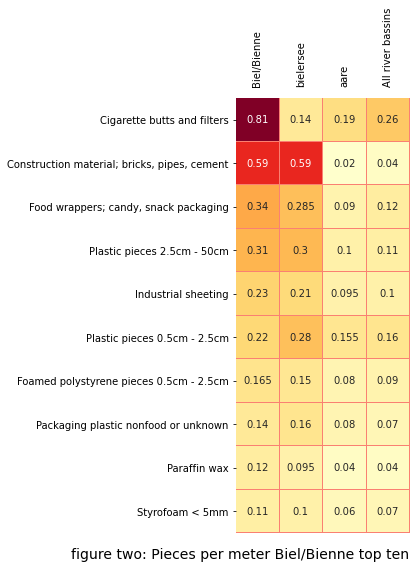

In [6]:
top_ten_pcsm = ac.agg_pcs_m_by_city_feature_basin_all(a_data[(a_data.quantity > 0)], levels, agg_cols={"pcs_m":"median"}, national=True)
tt_pcsm = m_ap_code_to_description(top_ten_pcsm, code_description_map, ut.use_this_key).sort_values(by=levels['city'], ascending=False)[:10]

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(tt_pcsm.sort_values(by=levels['city'], ascending=False), cmap='YlOrRd', annot=True, fmt='.3', ax=ax, square=True, cbar=False, linewidth=.05, linecolor='salmon')
ax.tick_params(**ck.xlabels_top, **ck.no_xticks)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_ylabel("")
ax.set_xlabel("figure two: Pieces per meter Biel/Bienne top ten", **ck.label_r14)
        
plt.tight_layout()
plt.show()

The first thing to notice is that _not all of the most frequently found objects are found in the greatest quantities_. There are six objects that were found the most frequenlty AND are also found in the top ten by pieces per meter:

1. Cigarette butts and filters
2. Food wrappers; candy, snack packaging
3. Plastic pieces 0.5cm - 2.5cm
4. Plastic pieces 2.5cm - 50cm
5. Foamed polystyrene pieces 0.5cm - 2.5cm
6. Industrial sheeting

These are the objects that were found the most frequently but not in large quantities:

1. Foil wrappers, aluminum foil                                 
2. Foamed plastic  for thermal insulation or packing material
3. Foam polystyrene; expanded beads/balls  2.5cm - 50cm
4. Tobacco; plastic  packaging, containers

These are the objects that were found in large quantities but not as often as the other objects:

1. Styrofoam < 5mm
2. Parafin wax
3. Packaging plastic nonfood or unknown
4. Construction material; bricks, pipe cement

#### **With this observation we can answer questions 3 and 4**

In [7]:
objs_both = list(set(top_ten_pcsm.sort_values(by=levels['city'], ascending=False)[:10].index)&set(the_top_ten))
objs_pcs = list(set(top_ten_pcsm.sort_values(by=levels['city'], ascending=False)[:10].index) - set(objs_both))
objs_fail = list(set(the_top_ten) - set(objs_both))


pcs_d_both = a_data[(a_data.quantity > 0)&(a_data.city == levels['city'])&(a_data.code.isin(objs_both))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
pcs_d_pcs = a_data[(a_data.quantity > 0)&(a_data.city == levels['city'])&(a_data.code.isin(objs_pcs))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
pcs_d_fail = a_data[(a_data.quantity > 0)&(a_data.city == levels['city'])&(a_data.code.isin(objs_fail))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
pcs_d_all = a_data[(a_data.quantity > 0)&(a_data.city == levels['city'])].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])

In [8]:
print(F"\nThe average pieces per meter per survey in Biel/Bienne was ~ {math.ceil(pcs_d_all['mean'])}, the minimum value was {round(pcs_d_all['min'], 2)} and the max was {round(pcs_d_all['max'], 2)}\n")

print("HIGH FAIL RATE & HIGH PIECES PER METER - objects found the most often and in the greatest quantities\n")
for i,x in enumerate([code_description_map[x] for x in objs_both]):
    print(F"{str((i+1))}. {x}")    
print(F"\nCombined they had an average pieces per meter per survey of {round(pcs_d_both['mean'], 2)}, a min of {round(pcs_d_both['min'], 2)} and max of {round(pcs_d_both['max'], 2)}")

print("\nLOW FAIL RATE & HIGH PIECES PER METER - objects found less often but in important quantities\n")
for i,x in enumerate([code_description_map[x] for x in objs_pcs ]):
    print(F"{str((i+1))}. {x}")    
print(F"\nCombined they had an average pieces per meter per survey of {round(pcs_d_pcs['mean'], 2)}, a min of {round(pcs_d_pcs['min'], 2)} and max of {round(pcs_d_pcs['max'], 2)}")

print("\nHIGH FAIL RATE & LOW PIECES PER METER - objects found often but in reduced quantities:\n")
for i,x in enumerate([code_description_map[x] for x in objs_fail]):
    print(F"{str((i+1))}. {x}")    
print(F"\nCombined they had an average pieces per meter per survey of {round(pcs_d_fail['mean'], 2)}, a min of {round(pcs_d_fail['min'], 2)} and max of {round(pcs_d_fail['max'], 2)}")


The average pieces per meter per survey in Biel/Bienne was ~ 5, the minimum value was 0.91 and the max was 9.33

HIGH FAIL RATE & HIGH PIECES PER METER - objects found the most often and in the greatest quantities

1. Foamed polystyrene pieces 0.5cm - 2.5cm
2. Industrial sheeting
3. Cigarette butts and filters
4. Plastic pieces 2.5cm - 50cm
5. Plastic pieces 0.5cm - 2.5cm
6. Food wrappers; candy, snack packaging

Combined they had an average pieces per meter per survey of 2.45, a min of 0.34 and max of 5.48

LOW FAIL RATE & HIGH PIECES PER METER - objects found less often but in important quantities

1. Styrofoam < 5mm
2. Paraffin wax
3. Packaging plastic nonfood or unknown
4. Construction material; bricks, pipes, cement

Combined they had an average pieces per meter per survey of 0.41, a min of 0.02 and max of 1.09

HIGH FAIL RATE & LOW PIECES PER METER - objects found often but in reduced quantities:

1. Tobacco; plastic  packaging, containers
2. Foil wrappers, aluminum foil
3. Foam

By combining the results from the two key indicators we are accounting for, on average, 3.2 out of the 5 pieces per meter or 64% of the objects found. 

**What about the rest?** There were 118 different categories used, so far we have accounted for 64% of the 3,047 objects  with only 14 categories. That leaves ~ 1,098 objects spread out between 104 categories⁵. 

As you will see this result is not uncommon, a relatively small group of objects make up a large percentage of the objects found. This is true even in the marine environment a quick check of the survey results from Marine Litter Watch⁶ reveals that the top ten in Biel/Bienne share four common objects with the top ten items in the EU:

2. Food wrappers; candy, snack packaging
3. Foam polystyrene; expanded beads/balls  2.5cm - 50cm
4. Cigarette butts and filters
5. Plastic pieces 2.5cm - 50cm

⁵ Find the full list of objects found at the end of this article<br>
⁶ https://www.eea.europa.eu/themes/water/europes-seas-and-coasts/assessments/marine-litterwatch/data-and-results/marine-litterwatch-data-viewer

### <span style="color:#008891">Putting it all together</span> 

The pieces per meter and fail rate help define the trash removed with more precision. The fail rate for an item or a group of items is an indicator of how likely we are to find the item or group of items. Pieces per meter gives a reference value for the minimum number of objects we expect to find given the previous results. The more samples we have the more confident we can be in our assumptions.

This opens the possibility of measuring mitigation techniques and reduction strategies using both of these indicators. The pieces per meter and the fail rate can vary from one location to another and from one season to another. If both the fail rate and the pieces per meter decline for a group of objects or an object year over year, it is safe to assume that the abundance of the object in the environment is in decline.

#### Next steps

> Understanding how the fail rate and pcs/m vary in response to things like population, infrastructure or time of the year.


> Grouping codes together to represent economic sectors or usage.


#### <span style="color:#008891">Practical excercise 1: Where would you go to find plastic industrial pellets on Bielersee?</span>

Plastic industrial pellets are the primary material used to produce plastic objects. They are disc or pellet shaped with a diameter of ~5mm.

Given the following survey results for Bielersee and assuming the surveys were done according to protocol: 

1. Where do you think your chances are the best of finding one?
2. Around how many would you expect to find?
3. Why did you pick that location? How sure are you of your choice?


In [9]:
aggs = {'loc_date':'nunique', 'fail':'sum', 'pcs_m':'mean', "quantity":"sum"}
new_col_names = {"loc_date":"# of samples", "fail":"# fail", "pcs_m":"median pcs/m", "quantity":"#found"}


biel_g95 = a_data[(a_data.water_name_slug == levels['water_name_slug'])&(a_data.code == 'G112')].groupby(['location']).agg(aggs)
biel_g95.rename(columns=new_col_names, inplace=True)

In [10]:
biel_g95

,# of samples,# fail,median pcs/m,#found
location,,,,
bielersee_vinelz_fankhausers,12,9,0.1275,22
camp-des-peches,1,0,0.0000,0
gals-reserve,2,0,0.0000,0
ligerz-strand,2,0,0.0000,0
luscherz-plage,4,2,0.0150,3
luscherz-two,1,0,0.0000,0
mullermatte,12,9,0.0725,37
nidau-strand,1,1,0.0800,2
strandboden-biel,2,2,0.0650,7


#### Have a great day

This project was made possible by the Swiss federal office for the environment.

This document originates from https://github.com/hammerdirt-analyst/iqals all copyrights apply.

In [11]:
author = "roger@hammerdirt.ch"
my_message = "Statistics is fun when you do it outside"
print(F"\nProduced by: {author}\nDate: {today}\n\n{my_message}")


Produced by: roger@hammerdirt.ch
Date: 2021-04-26

Statistics is fun when you do it outside


#### <span style="color:#008891">Biel/Bienne: all objects identified</span>

In [12]:
pd.set_option('display.max_rows', None)
b_codes = biel[biel.quantity > 0].groupby('code').agg({'quantity':'sum', 'pcs_m':'median', 'fail':'sum'})
b_codes['fail_rate'] = b_codes.fail/len(biel.loc_date.unique())
b_codes['item'] = b_codes.index.map(lambda x: ut.use_this_key(x, code_description_map))
b_codes = b_codes[['item', 'quantity', 'pcs_m', 'fail', 'fail_rate']]


b_codes.sort_values(by='quantity', ascending=False)

,item,quantity,pcs_m,fail,fail_rate
code,,,,,
G27,Cigarette butts and filters,706,0.810,16,1.0000
G30,"Food wrappers; candy, snack packaging",231,0.340,15,0.9375
G78,Plastic pieces 0.5cm - 2.5cm,185,0.220,15,0.9375
G79,Plastic pieces 2.5cm - 50cm,175,0.310,14,0.8750
G67,Industrial sheeting,150,0.230,13,0.8125
G81,Foamed polystyrene pieces 0.5cm - 2.5cm,110,0.165,14,0.8750
G941,Packaging plastic nonfood or unknown,95,0.140,11,0.6875
G200,"Glass or ceramic drink bottles, pieces",92,0.080,12,0.7500
G940,Foamed EVA (flexible plastic) for crafts & wat...,84,0.090,7,0.4375
